<a href="https://colab.research.google.com/github/Kevin-Lyy/CVFinalProject/blob/master/lego_voxels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README 

Our data is from the [Amsterdam Library of Object Images (ALOI)](https://aloi.science.uva.nl/)

To choose an object go to:  
`ALOI Collection` > `Object Images` > `[img]` and click on any image 

<br>

## Run Instructions

1. Run the pip installs  (cell below **Installs**)
2. Restart the runtime so the installs work correctly - you *will* get errors otherwise 
3. Run all cells 
4. Modify **`lego_image`** and **`lego_image_deg`** (cell below **Run**) as instructed, then run all cells below those cells to see results
> If the visualization does not work immediately, clear the output and rerun it :) 

## Installs 

Run the cell below to install required libraries, then restart the runtime so everything works correcty :) 

In [1]:
!pip install scikit-image
!pip install open3d
!pip install pyntcloud
!pip install pythreejs

## Imports

In [2]:
import math
import random 
import urllib.request
import colorsys

import numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean

from skimage.draw import line

import cv2
from google.colab.patches import cv2_imshow
import imutils
from PIL import Image


import open3d as o3d
from pyntcloud import PyntCloud

In [3]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [4]:
from google.colab import output
output.enable_custom_widget_manager()

# Setup

In [5]:
!wget https://raw.githubusercontent.com/Kevin-Lyy/CVFinalProject/master/lego_colors.txt 

--2022-05-22 22:17:59--  https://raw.githubusercontent.com/Kevin-Lyy/CVFinalProject/master/lego_colors.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240 [text/plain]
Saving to: ‘lego_colors.txt’

lego_colors.txt     100%[===================>]     240  --.-KB/s    in 0s      

2022-05-22 22:17:59 (8.29 MB/s) - ‘lego_colors.txt’ saved [240/240]



# util

In [6]:
def img_from_url (url):
    url_response = urllib.request.urlopen(url)
    return cv2.imdecode(np.array(bytearray(url_response.read()), dtype=np.uint8), -1)

In [7]:
def cv2_to_pil(img):
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def pil_to_cv2(img):
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR) 

## color

In [8]:
def hex_to_rgb(hex):
    return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4)) 

def rgb_to_hex(r, g, b):
    return ('{:X}{:X}{:X}').format(r, g, b)

def rgb_to_hsv(rgb):
    return colorsys.rgb_to_hsv(*rgb)

def hsv_to_rgb(hsv):
    return colorsys.hsv_to_rgb(*hsv)

## lego

In [9]:
def get_lego_colors(file_path='lego_colors.txt', dct=False):
    data = open(file_path,'r')
    if dct: 
        return {hex_to_rgb(color.strip()): color.strip() for color in data.readlines()}
    return [hex_to_rgb(color.strip()) for color in data.readlines()]

lego_colors = get_lego_colors()
lego_color_dict = get_lego_colors(dct=True)

In [10]:
def recolor_lego(img, valid_colors=lego_colors, resize=False):
    if not resize: 
        img = img.copy().astype('uint8')
    else:
        img = cv2.resize(img.astype('uint8'),(100,100))
        
    valid_colors = np.asarray(valid_colors)
    out = valid_colors[cdist(img.reshape(-1,3),valid_colors).argmin(1)].reshape(img.shape)
    # cv2_imshow(imutils.resize(out.astype('uint8'),width=300))
    return out 

## voxels

In [11]:
LEGO_VOXEL_WIDTH = 7.8
LEGO_VOXEL_HEIGHT = 9.6
LEGO_VOXEL_SCALE = LEGO_VOXEL_HEIGHT/LEGO_VOXEL_WIDTH

In [12]:
'''
calculates the line that goes through the center of the voxel box
of length width of the image oriented at angle theta
in the column, layer parameter space
returns all the points on the line
'''
def image_line(image, theta):
    width, height = image.size
    rad = math.radians(theta)
    cw = width/2
    x1 = int(cw + cw*math.cos(rad))
    y1 = int(cw + cw*math.sin(rad))
    x2 = int(cw - cw*math.cos(rad))
    y2 = int(cw - cw*math.sin(rad))
    print("Image line for ", theta, ": ",x1,y1,x2,y2)
    return ((x1,y1),(x2,y2))


In [13]:
'''
returns the image col corresponding to the point on the projected image line
'''
def image_line_to_col(image_line, c, l, width):
    return c*width/len(image_line)


In [14]:
def projection_line(col, layer, image, theta):
    width, height = image.size
    rad = math.radians(theta)
    coordinates = []
    cos_value = math.cos(rad)
    sin_value = math.sin(rad)
    if(sin_value!=0):
        # CASE1: x = 0
        x = 0
        y = int(-cos_value*(x-col)/sin_value + layer)
        if(y >= 0 and y < width):
            coordinates.append((x,y))
        # CASE2: x = width -1
        x = width -1
        y = int(-cos_value*(x-col)/sin_value + layer)
        if(y >= 0 and y < width):
            coordinates.append((x,y))
    if(cos_value!=0):
        # CASE3: y = 0
        y = 0
        x = int(-(y-layer)*sin_value/cos_value + col)
        if (x >= 0 and x < width):
            coordinates.append((x,y))
        # CASE4: y = width -1
        y = width- 1
        x = int(-(y-layer)*sin_value/cos_value + col)
        if (x >= 0 and x < width):
            coordinates.append((x,y))
    coordinates = list(set(coordinates))
    #print("Projection Line for ", col, " ", layer, ": ", coordinates)
    if len(coordinates) == 1:
        return coordinates+coordinates
    if len(coordinates) == 2:
        return coordinates
    if len(coordinates) == 3:
        if (0,0) in coordinates:
            coordinates.remove((0,0))
            return coordinates
        if (width-1,width-1) in coordinates:
            coordinates.remove((width-1,width-1))
            return coordinates
        if (0,width-1) in coordinates:
            coordinates.remove((0,width-1))
            return coordinates
        if (width-1,0) in coordinates:
            coordinates.remove((width-1,0))
            return coordinates
    return []


In [15]:
def line_intersection(lineA, lineB, width):
    #print(lineA, lineB)
    x1 = lineA[0][0]
    y1 = lineA[0][1]
    x2 = lineA[1][0]
    y2 = lineA[1][1]
    x3 = lineB[0][0]
    y3 = lineB[0][1]
    x4 = lineB[1][0]
    y4 = lineB[1][1]
    det = ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) )
    if det == 0: return []
    px= ( (x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4) ) / det
    py= ( (x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4) ) / det
    #if px > 0 and px < width and py > 0 and py < width:
    return (int(px),int(py))


In [16]:
def delta_color(colorA, colorB):
    R = colorA[0]-colorB[0]
    G = colorA[1]-colorB[1]
    B = colorA[2]-colorB[2]
    return (R+G+B)/3


In [17]:
def consistent(colors, threshold):
    for i in range(len(colors)):
        for j in range(i+1, len(colors)):
            if delta_color(colors[i], colors[j]) > threshold:
                return False
    return True


In [18]:
def average_color(colors):
    color = [0,0,0]
    for i in range(len(colors)):
        color[0] += colors[i][0]
        color[1] += colors[i][1]
        color[2] += colors[i][2]
    color[0] = int(color[0]/len(colors))
    color[1] = int(color[1]/len(colors))
    color[2] = int(color[2]/len(colors))
    return color


In [19]:
def rect_points(coordA, coordB):
    points = [[coordA[0], i] for i in range(coordB[1],coordA[1])]
    points += [[i, coordA[1]] for i in range(coordA[0],coordB[0])]
    points += [[coordB[0], i] for i in range(coordA[1],coordB[1],-1)]
    points += [[i, coordB[1]] for i in range(coordB[0],coordA[0],-1)]
    return points



In [20]:
def background_threshold(color, t):
    return color[0] < t and color[1] < t and color[2] < t


In [21]:
def obscured(pointc, pointl, row, theta, coordA, coordB, voxels):
    endpoint = []
    if theta < 45 or theta > 315:
        if coordA[1] < pointl: endpoint = coordA
        elif coordB[1] < pointl: endpoint = coordB
    if theta < 135 and theta > 45:
        if coordA[0] > pointc: endpoint = coordA
        elif coordB[0] > pointc: endpoint = coordB
    if theta < 225 and theta > 135:
        if coordA[1] > pointl: endpoint = coordA
        elif coordB[1] > pointl: endpoint = coordB
    if theta < 315 and theta > 225:
        if coordA[0] < pointc: endpoint = coordA
        elif coordB[0] < pointc: endpoint = coordB
    #print(pointc, pointl, row, theta, coordA, coordB, endpoint)
    if endpoint == []:
        return True
    points = list(zip(*line(pointc,pointl,endpoint[0], endpoint[1])))
    for i in range(1,len(points)):
        if (voxels[points[i][1]][row][points[i][0]] != [0,0,0]).all():
            return True
    return False


In [22]:
def voxel_coloring(images, angles, threshold=30):
    image_lines = [image_line(images[i], angles[i]) for i in range(len(images))]
    num_images = len(images)
    width, height = images[0].size
    voxels = np.full([width, height, width, 3], 255)
    cw = int((width-1)/2)
    coordA = [0, width-1] #xz coordinates
    coordB = [width-1, 0] #xz coordinates
    #SHAPE CARVING
    while(coordB[0]-coordA[0] > 1):
        for row in range(height):
            for p in rect_points(coordA, coordB):
                for i in range(num_images):
                    projected = projection_line(p[0],p[1], images[i], angles[i])
                    projected_point = []
                    if projected != []: projected_point = line_intersection(projected, image_lines[i], width)
                    if len(projected_point) == 2:
                        ac = int(euclidean(projected_point, image_lines[i][1]))
                        if ac < width:
                            adjusted_point = [ac, row]
                            color = images[i].getpixel(tuple(adjusted_point))
                            if background_threshold(color,40):
                                voxels[p[1]][row][p[0]] = [0,0,0]
                                break
                    else:
                        voxels[p[1]][row][p[0]] = [0,0,0]
                        break
                continue
        #set next layer coords
        coordA = [coordA[0]+1, coordA[1]-1]
        coordB = [coordB[0]-1, coordB[1]+1]
    
    coordA = [0, width-1] #xz coordinates
    coordB = [width-1, 0] #xz coordinates
    #VOXEL COLORING
    while(coordB[0]-coordA[0] > 1):
        for row in range(height):
            for p in rect_points(coordA, coordB):
                #vp = (p[0], row, p[1]) #(x,y,z) or (col,row,layer)
                coords = [] # store coordinates of point projected on images
                colors = [] # store colors of point projected on images
                image_indexes = [] # store index of relevant images
                if (voxels[p[1]][row][p[0]] != [0,0,0]).all():
                    for i in range(num_images):
                        projected = projection_line(p[0],p[1], images[i], angles[i])
                        projected_point = []
                        if projected != []:
                            projected_point = line_intersection(projected, image_lines[i], width)
                        #print("Projected Point: ", projected_point)
                        # is voxel obscured?
                        if not obscured(p[0], p[1], row, angles[i], projected[0], projected[1], voxels):
                            if len(projected_point) == 2:
                                ac = int(euclidean(projected_point, image_lines[i][1]))
                                if ac < width:
                                    adjusted_point = [ac, row]
                                    #print("Adjusted Point: ", adjusted_point)
                                    color = images[i].getpixel(tuple(adjusted_point))
                                    if color != (0,0,0):
                                        colors.append(color)
                                        image_indexes.append(i)
                                        coords.append(adjusted_point)
                    #print(colors)
                    #if (len(colors) > 0 and consistent(colors, threshold)) or len(colors) == 1:
                    if len(colors) > 0:
                        color = average_color(colors)
                        #if color != [0,0,0]:
                        voxels[p[1]][row][p[0]] = color
                            #voxels.append([p[0], row, p[1], color[0], color[1], color[2]])
                        for i in range(len(image_indexes)):
                            images[image_indexes[i]].putpixel(coords[i], (0,0,0))
                    #if color != [0,0,0]: print(colors, end=" ")
        #set next layer coords
        coordA = [coordA[0]+1, coordA[1]-1]
        coordB = [coordB[0]-1, coordB[1]+1]
    return voxels


In [23]:
def reconstruction_size(image, max_height):
    im_width, im_height = image.size
    image = image.resize((im_width,int(im_height//LEGO_VOXEL_SCALE)), Image.Resampling.BILINEAR)
    new_im_height = int(max_height//LEGO_VOXEL_HEIGHT)
    scale = new_im_height/im_height
    new_im_width = int(im_width*scale)
    return new_im_width, new_im_height


In [24]:
def build_images(voxels):
    voxels = np.swapaxes(voxels, 0, 1)
    scaled_width = len(voxels)*5
    for i in range(len(voxels)):
        Image.fromarray(voxels[i].astype('uint8'), 'RGB').resize((scaled_width, scaled_width), Image.Resampling.BILINEAR).save(str(i)+"layer_build.png")


In [25]:
def driver(images, angles):
    images = [cv2_to_pil(i) for i in images]
    scaled_width, scaled_height = reconstruction_size(images[0], 500)
    images = [i.resize((scaled_width, scaled_height), Image.Resampling.BILINEAR) for i in images]

    #INSERT IMAGE RECOLOR
    voxels = voxel_coloring(images, angles)
    points = []
    for layer in range(len(voxels)):
        for row in range(len(voxels[layer])):
            for col in range(len(voxels[layer][row])):
                color = voxels[layer][row][col]
                R = color[0]/255
                G = color[1]/255
                B = color[2]/255
                points.append([col, row, layer, R,G,B])
                #voxels[layer][row][col] = [color[2],color[1],color[0]]
                
    points = np.array(points)
    build_images(voxels)
    np.save("voxels_500", voxels)
    np.save("points_500", points)


## 3d 

In [26]:
def visible_axes(b=True):
    return {'xaxis': {'visible': b}, 'yaxis': {'visible': b}, 'zaxis': {'visible': b}, 'aspectmode':'data',}

    margin=dict(l=0, r=0, b=0, t=0)

In [27]:
def draw_geometries(geometries):
    graph_objects = []
    view_axes=True

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()
        
        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], 
                                      mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_vertex_colors():
                colors = np.asarray(geometry.vertex_colors)
            elif geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)
            
            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], 
                                i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], 
                                facecolor=colors, opacity=1)
            graph_objects.append(mesh_3d)
        
    fig = go.Figure(
        data=graph_objects,
        layout=dict(scene=visible_axes(view_axes))
    )
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

o3d.visualization.draw_geometries = draw_geometries # replace function

In [28]:
def img_unique_colors(img):
    for color in np.unique(img.reshape(-1, img.shape[-1]),axis=0):
        print(f"{color}\t{len(list(zip(*np.where(np.all(img == color, axis=-1)))))}")
        cv2_imshow(np.full((100, 100, 3), (color)))

# images

0	https://aloi.science.uva.nl/www-images/62/62_r0.jpg


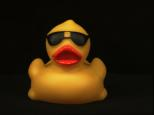

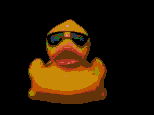




30	https://aloi.science.uva.nl/www-images/62/62_r30.jpg


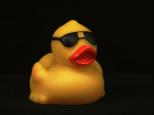

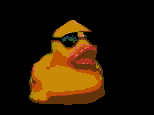




60	https://aloi.science.uva.nl/www-images/62/62_r60.jpg


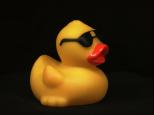

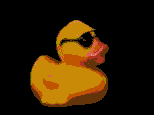




90	https://aloi.science.uva.nl/www-images/62/62_r90.jpg


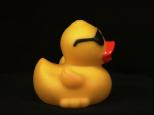

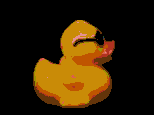




120	https://aloi.science.uva.nl/www-images/62/62_r120.jpg


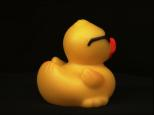

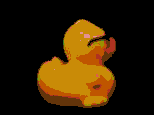




150	https://aloi.science.uva.nl/www-images/62/62_r150.jpg


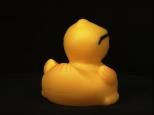

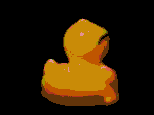




180	https://aloi.science.uva.nl/www-images/62/62_r180.jpg


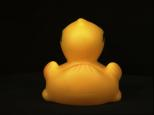

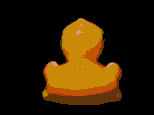




210	https://aloi.science.uva.nl/www-images/62/62_r210.jpg


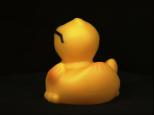

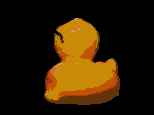




240	https://aloi.science.uva.nl/www-images/62/62_r240.jpg


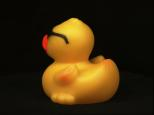

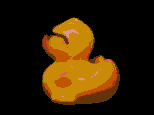




270	https://aloi.science.uva.nl/www-images/62/62_r270.jpg


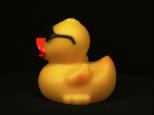

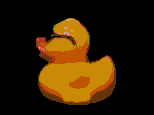




300	https://aloi.science.uva.nl/www-images/62/62_r300.jpg


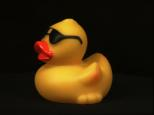

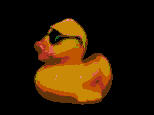




330	https://aloi.science.uva.nl/www-images/62/62_r330.jpg


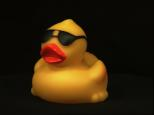

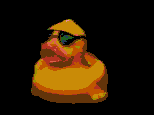

In [29]:
png4_rot60 = []
png4_rot60_lego = []

for deg in range(12):
    img_url = f"https://aloi.science.uva.nl/www-images/62/62_r{deg*30}.jpg"
    print(f"{deg*30}\t{img_url}")
    png4_rot60.append(img_from_url(img_url))
    cv2_imshow(png4_rot60[-1])
    png4_rot60_lego.append(recolor_lego(png4_rot60[-1].copy()))
    cv2_imshow(png4_rot60_lego[-1])
    print("\n\n")

# Run


## Modify the following variables as desired

**`lego_image`** &nbsp; list of images (cv2/numpy array) 

**`lego_image_deg`** &nbsp; degrees of the corresponding images, used for calculations 

<br>


#### Run Recommendations 

To select an object and find images:  

[`ALOI Collection`](https://aloi.science.uva.nl/) > `Object Images` > `[img]` > `object orientations` 

Open any image in a new tab and copy the link to it  
> ```python
"https://aloi.science.uva.nl/www-images/62/62_r0.jpg"
```


Make it an f-string and replace the degree with `{deg*30}`  
> ```python
f"https://aloi.science.uva.nl/www-images/62/62_r{deg*30}.jpg"
```

If you want to use different degrees, the orientations on the site are **`[0,5,...,355]`**

We are currently using 30º

Modify `deg*30` with your desired degree and `range(12)` with the desired range

Run all cells below it 

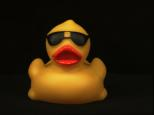

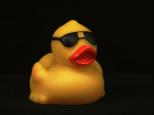

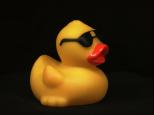

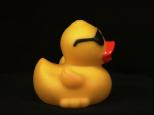

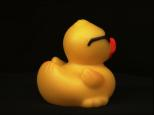

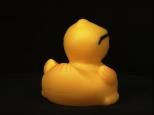

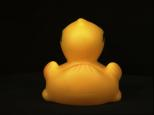

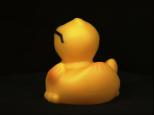

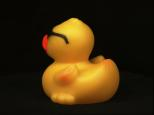

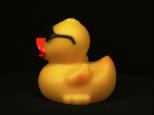

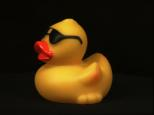

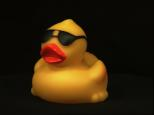

[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]


In [34]:
lego_image = [img_from_url(f"https://aloi.science.uva.nl/www-images/62/62_r{deg*30}.jpg") for deg in range(12)]
lego_image_deg = [deg*30 for deg in range(12)]

for i in lego_image:
    cv2_imshow(i)

print(lego_image_deg)

## Voxelify

In [37]:
driver(lego_image, lego_image_deg)

Image line for  0 :  69 34 0 34
Image line for  30 :  64 51 4 17
Image line for  60 :  51 64 17 4
Image line for  90 :  34 69 34 0
Image line for  120 :  17 64 51 4
Image line for  150 :  4 51 64 17
Image line for  180 :  0 34 69 34
Image line for  210 :  4 17 64 51
Image line for  240 :  17 4 51 64
Image line for  270 :  34 0 34 69
Image line for  300 :  51 4 17 64
Image line for  330 :  64 17 4 51


In [38]:
voxels_500 = np.load('/content/points_500.npy')
voxels_500.shape

(247572, 6)

## Visualize Voxels

If the visualization does not work right away, clear the output and then rerun it 

In [43]:
cloud = voxels_500[:,:3]
colors = voxels_500[:,3:]
transparent_voxels = voxels_500[np.all(voxels_500[:,3:] != [0, 0, 0], axis=-1)]
valid_colors = np.asarray(lego_colors)
cloud = transparent_voxels[:,:3]
colors = transparent_voxels[:,3:]

In [44]:
o3_cloud = o3d.geometry.PointCloud()
o3_cloud.points = o3d.utility.Vector3dVector(cloud)
o3_cloud.colors = o3d.utility.Vector3dVector(colors.astype(float))

pycloud = PyntCloud.from_instance("open3d", o3_cloud)
pycloud.plot(point_size=0.05, opacity=0.1)

voxelgrid_id = pycloud.add_structure("voxelgrid")
voxelgrid = pycloud.structures[voxelgrid_id]

/usr/local/lib/python3.7/dist-packages/pythreejs/traits.py:203: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(31.572239170225746, 84.55143380109823, 111.1…